In [94]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

#the above imports the plotting library matplotlib

In [93]:
import pymongo as pm
import numpy as np
import h5py
import scipy as sp
import scipy.stats as stats

In [2]:
conn = pm.MongoClient(port=22335)
db = conn['mturk']

In [3]:
db.collection_names()

[u'system.indexes',
 u'task3',
 u'labels',
 u'task9',
 u'HvM_7x7',
 u'objectome48',
 u'objectome48_validation',
 u'objectome64',
 u'xiaoxuan_test',
 u'learning_2wayface',
 u'learning_6wayface',
 u'objectome32',
 u'objectome32_validation',
 u'objectome_pilot',
 u'subjective_similarity',
 u'learning_6wayface_fb',
 u'learning_6wayface_var3_fb',
 u'car_recognition_8way',
 u'labels_HvM',
 u'imageNet16',
 u'temporal_learning',
 u'TEST',
 u'compensate',
 u'HvM',
 u'HvM_original',
 u'temporal_learning_HvM',
 u'rishi_test',
 u'image_embedding',
 u'basic_learning',
 u'HvM_face_embedsize_learning',
 u'monkobjectome',
 u'imagenet_psychophysics',
 u'diego_backup',
 u'pixel_hard_random_2_ways',
 u'1000_random_2_ways',
 u'hard_synsets_eight_way',
 u'model_hard_random_2_ways',
 u'hardest_8_random_2_ways',
 u'stratified8ways',
 u'objectome24_notxtbg',
 u'HvM_face_learning',
 u'basic_learning_short',
 u'HvM_face_learning_short',
 u'basic_learning_long',
 u'HvM_face_learning_long',
 u'hvm_timing',
 u'hvm

In [54]:
coll = db['hvm_basic_categorization_new']

In [55]:
r = coll.find()[0]

In [59]:
len(r['RT'])

192

In [147]:
r['ImgData'][0]['Sample'].keys()

[u'category',
 u'_id',
 u'obj',
 u'ryz_semantic',
 u'ty',
 u'filename',
 u'rxy',
 u's',
 u'rxz',
 u'ryz',
 u'bg_id',
 u'var',
 u'tz',
 u'rxy_semantic',
 u'rxz_semantic',
 u'id',
 u'size']

In [38]:
#ok let's load the data 
DATA_PATH = "/home/chengxuz/Class/psych253_2018/data/ventral_neural_data.hdf5"
Ventral_Dataset = h5py.File(DATA_PATH)

categories = Ventral_Dataset['image_meta']['category'][:]   #array of category labels for all images  --> shape == (5760,)
unique_categories = np.unique(categories)                #array of unique category labels --> shape == (8,)
objects = Ventral_Dataset['image_meta']['object_name'][:]   #array of object labels for all images --> shape == (5670,)
unique_objects = np.unique(objects)                      #array of unique object labels --> shape == (64,) 

objects_by_category = {c: np.unique(objects[categories == c]) 
                       for c in unique_categories}


In [148]:
def get_chosens_actuals_ids(collname, k):
    coll = db[collname]
    actuals = []
    chosens = []
    rts = []
    ids = []
    varlevels = []
    for r in coll.find():
        actual = np.array([_r['Sample'][k] for _r in r['ImgData']])
        varlevel = np.array([_r['Sample']['var'] for _r in r['ImgData']])
        idv = [_r['Sample']['id'] for _r in r['ImgData']]
        chosen_inds = np.array([_r['indexChosen'] for _r in r['Response']])
        chosen = np.array([_r['Test'][ind][k] for ind, _r in 
                                              zip(chosen_inds, r['ImgData'])])
        actuals.append(actual)
        chosens.append(chosen)
        rt = np.array(r['RT'])
        rts.append(rt)
        ids.append(idv)
        varlevels.append(varlevel)
    actuals = np.array(actuals)
    chosens = np.array(chosens)
    rts = np.array(rts)
    ids = np.array(ids)
    varlevels = np.array(varlevels)
    return actuals, chosens, rts, varlevels, ids

In [149]:
collnames = [('Basic_categorization', 'hvm_basic_categorization_new', 'category')] + \
            [(c + '_identification', 'hvm_subordinate_identification_%s' % c, 'obj') for c in unique_categories]

human_results = {}
for cn, cname, key in collnames:
    print('Getting %s/' % cname)
    human_results[cn] = get_chosens_actuals_ids(cname, key)

Getting hvm_basic_categorization_new/
Getting hvm_subordinate_identification_Animals/
Getting hvm_subordinate_identification_Boats/
Getting hvm_subordinate_identification_Cars/
Getting hvm_subordinate_identification_Chairs/
Getting hvm_subordinate_identification_Faces/
Getting hvm_subordinate_identification_Fruits/
Getting hvm_subordinate_identification_Planes/
Getting hvm_subordinate_identification_Tables/


In [155]:
newF = h5py.File('/mnt/data3/yamins/visual/human_behavior.hdf5', mode='a')

for cn, cname, k in collnames:
    grp = newF.create_group(cn)
    actuals, chosens, rts, vls, ids = human_results[cn]
    actuals = actuals.astype(str)
    chosens = chosens.astype(str)
    ids = ids.astype(str)
    vls = vls.astype(str)
    d = grp.create_dataset('actual', dtype=actuals.dtype, shape=actuals.shape)
    d[:] = actuals
    d.dims[0].label = 'subject' 
    d.dims[1].label = 'trial' 
    
    d = grp.create_dataset('chosen', dtype=chosens.dtype, shape=chosens.shape)
    d[:] = chosens
    d.dims[0].label = 'subject' 
    d.dims[1].label = 'trial'
    
    d = grp.create_dataset('reaction_time', dtype=rts.dtype, shape=rts.shape)
    d[:] = rts
    d.dims[0].label = 'subject' 
    d.dims[1].label = 'trial'
    
    d = grp.create_dataset('image_id', dtype=ids.dtype, shape=ids.shape)
    d[:] = ids
    d.dims[0].label = 'subject' 
    d.dims[1].label = 'trial'
    
    d = grp.create_dataset('variation_level', dtype=vls.dtype, shape=vls.shape)
    d[:] = vls
    d.dims[0].label = 'subject' 
    d.dims[1].label = 'trial'
    
newF.close()

In [51]:
from metrics import get_confusion_matrix

In [151]:
confmats = {}
for cn, cname, k in collnames:
    if 'Basic' in cn:
        ucats = unique_categories
    else:
        catn = cn.split('_')[0]
        ucats = objects_by_category[catn]
    preds, actuals, rts, vls, ids = human_results[cn]
    cms = np.array([get_confusion_matrix(p, a, ucats) for p, a in zip(preds, actuals)])
    confmats[cn] = {'all': cms}
    for v in ['V0', 'V3', 'V6']:
        cms = np.array([get_confusion_matrix(p[vl==v], a[vl==v], ucats) 
                             for p, a, vl in zip(preds, actuals, vls)])
        confmats[cn][v] = cms
                     

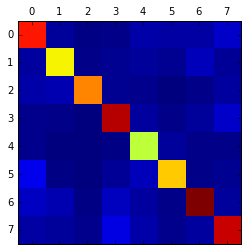

In [153]:
plt.matshow(confmats['Basic_categorization']['V6'].mean(0))

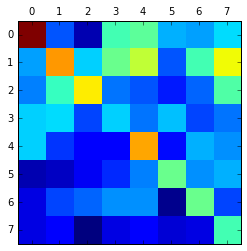

In [146]:
plt.matshow(confmats['Faces_identification'].mean(0))